In [1]:
from pyspark.mllib.recommendation import ALS
import math
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
import sys
try:
    sc.stop()
except:
    pass
sc = SparkContext(appName="movie_recommendation")
sqlContext = SQLContext(sc)

In [222]:
sql_password = ""

In [3]:
rating_df = sqlContext.read.format("jdbc").options(url="jdbc:mysql://localhost:3306/MovieDB",
                                       driver="com.mysql.jdbc.Driver",
                                       dbtable="ratings",user="root",password=sql_password).load()

ratings = rating_df.select('userId','movieId','rating').rdd

In [6]:
splits = ratings.randomSplit([0.8,0.2],10)
train_data = splits[0].repartition(3) #分区
val_data = splits[1].repartition(3)


iterations = 10
reg_parameter = 0.01
ranks = [4, 8, 12]
rank = 8
errors = []
min_error = 100000
best_rank = None
best_model = None

for rank in ranks:
    model = ALS.train(ratings, rank, iterations=iterations, lambda_=reg_parameter, seed=10)
    preds = model.predictAll(val_data.map(lambda row: (row[0],row[1]))).map(lambda r: ((int(r[0]), int(r[1])), float(r[2])))
    rates_and_preds = val_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(preds)
    err = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors.append(err)
    print('For rank %s the RMSE is %s' % (rank, err))
    if err < min_error:
        min_error = err
        best_rank = rank
        best_model = model
print('The best model was trained with rank %s' % best_rank)

For rank 4 the RMSE is 0.833464820625094
For rank 8 the RMSE is 0.7799226259469715
For rank 12 the RMSE is 0.747147682055014
The best model was trained with rank 12


In [7]:
user_feature = best_model.userFeatures()
movie_feature = best_model.productFeatures()

In [123]:
def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

from scipy import spatial
def cosine_similarity(x,y):
    return 1 - spatial.distance.cosine(x,y)

In [9]:
user_feature_df = user_feature.map(lambda x:[x[0],convert_vector(x[1])]).toDF().selectExpr("_1 as id","_2 as feature")
movie_feature_df = movie_feature.map(lambda x:[x[0],convert_vector(x[1])]).toDF().selectExpr("_1 as id","_2 as feature")

In [10]:
user_feature_df.write.format('jdbc').options(
    url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
    driver = 'com.mysql.jdbc.Driver',
    dbtable = 'user_feature',
    ).mode('append').save()

In [11]:
movie_feature_df.write.format('jdbc').options(
    url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
    driver = 'com.mysql.jdbc.Driver',
    dbtable = 'movie_feature',
    ).mode('append').save()

In [12]:
link_df = sqlContext.read.format("jdbc").options(
    url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
    dbtable = "links", driver = 'com.mysql.jdbc.Driver').load()
movie_df = sqlContext.read.format("jdbc").options(
    url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
    dbtable = "movies", driver = 'com.mysql.jdbc.Driver').load()

Successfully imported tmdbsimple!


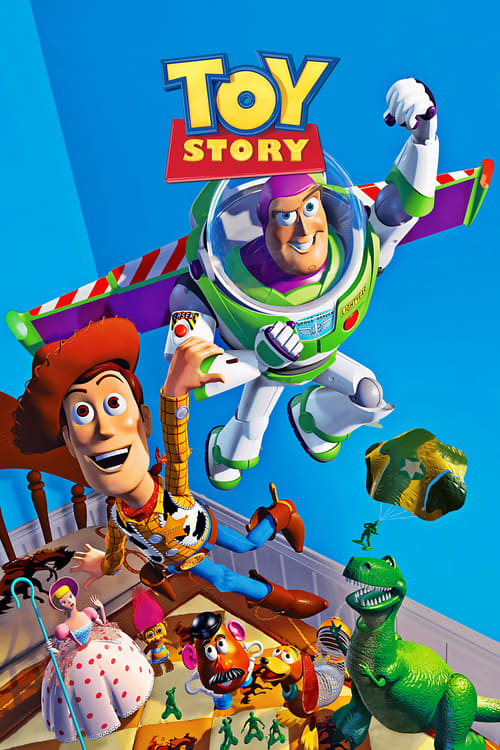

In [13]:
try:
    from IPython.display import Image, display
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = '31362d194b7b8e33df9fdbfa6e138b49'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = link_df.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [112]:
import numpy as np
from IPython.display import Image, HTML, display
import tmdbsimple as tmdb
tmdb.API_KEY = '31362d194b7b8e33df9fdbfa6e138b49'
def get_poster_url(id):
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        movie = tmdb.Movies(id).info()
        poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
        return poster_url
    except:
        return "KEY_ERR"

def get_tmdbId(id):
    return link_df.where(link_df["movieId"]==id).collect()[0].tmdbId

def get_title(id):
    return movie_df.where(movie_df["movieId"]==id).collect()[0].title

def get_movies_for_user(the_id, num = 10):
    query = "(select links.movieId, tmdbId, rating from links, ratings where userId = " + str(the_id) + " and links.movieId=ratings.movieId order by rating desc limit "+ str(num) +" ) as result"
    #Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    movies_df = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load()
    return movies_df

def get_movies_for_user_with_genre(the_id, genre, num=10):
    query = "(select links.movieId, tmdbId, rating from links, ratings, movies where movies.movieId = ratings.movieId and genres like '%"+genre+"%'and userId = " + str(the_id) + " and links.movieId=ratings.movieId order by rating desc limit "+ str(num) +" ) as result"
    #Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    movies_df = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load()
    return movies_df

def get_movies_by_genre(genre):
    query = "(select movies.movieId, title, tmdbId, feature from links, movies, movie_feature where genres like '%" + genre + "%' and movies.movieId = id and id = links.movieId) as result"
    movies_df = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load()
    return movies_df

def get_score_by_feature(user_feature, movie_feature):
    return np.dot(reverse_convert(user_feature),reverse_convert(movie_feature))




In [113]:
def display_poster(the_id,user_movies, recs):
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        img_url = get_poster_url(movie.tmdbId)
        title = get_title(movie.movieId)
        rate = movie.rating
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (title, img_url,rate)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        movie_id = rec.product
        tmdb_id = get_tmdbId(movie_id)
        img_url = get_poster_url(tmdb_id)
        score = rec.rating
        title = get_title(movie_id)
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (title, img_url, score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))
    

In [114]:
def display_user_recs(the_id, num=10):
    user_movies = get_movies_for_user(the_id,num).collect()
    recs = best_model.recommendProducts(the_id,num)
    display_poster(the_id,user_movies,recs)

In [218]:
def display_user_recs_with_genre(the_id,genre,num=10):
    query = "(select feature from user_feature where id = "+ str(the_id) +") as result"
    user_feature_df = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load()
    user_feature = user_feature_df.collect()[0].feature
    query = "(select movieId from ratings where userID = "+ str(the_id) +") as result"
    rated_ids = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load().rdd.map(lambda x:x[0]).collect()
    
    movies_df = get_movies_by_genre(genre)
    recs = movies_df.rdd.filter(lambda pair:pair[0] not in rated_ids).map(lambda pair:(pair[0],pair[1],pair[2],get_score_by_feature(user_feature,pair[3]))).sortBy(lambda x:x[3],False).take(num)
    user_movies = get_movies_for_user_with_genre(the_id,genre,num).collect()
        
    display(HTML("<h2>Get recommended movies with genre %s for user id %s</h2>" % (genre, the_id)))
    display(HTML("<h4>The user has rated the following movies with genre %s highly:</h4>" %genre))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        img_url = get_poster_url(movie.tmdbId)
        title = get_title(movie.movieId)
        rate = movie.rating
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (title, img_url,rate)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        movie_id = rec[0]
        tmdb_id = rec[2]
        img_url = get_poster_url(tmdb_id)
        score = rec[3]
        title = rec[1]
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (title, img_url, score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))


In [195]:
def display_similar_movie(movie_id,num=10):
    query = "(select id, title, tmdbId,feature from links, movies, movie_feature where movies.movieId = id and links.movieId = id) as result"
    movie_feature_rdd = sqlContext.read.format("jdbc").options(
        url = "jdbc:mysql://localhost:3306/MovieDB?user=root&password="+sql_password,
        dbtable = query, driver = 'com.mysql.jdbc.Driver').load().rdd
    the_movie = movie_feature_rdd.filter(lambda x:x[0]==movie_id).collect()[0]
    feature = the_movie.feature
    title = the_movie.title
    tmdb_id = the_movie.tmdbId
    img_url = get_poster_url(tmdb_id)
    
    recs = movie_feature_rdd.filter(lambda x:x[0]!=movie_id).map(lambda x:(x[0],x[1],x[2],cosine_similarity(reverse_convert(feature),reverse_convert(x[3])))).sortBy(lambda x:x[3],False).take(num)
    
    display(HTML("<h2>Get similar movies for id_%s:</h2>"%movie_id))
    
    display(HTML("<h4>Chosen movie:</h4>"))
    movie_html = "<table border=0><td><h5>%s</h5><img src=%s width=150></img></td></table>" % (title, img_url)
    display(HTML(movie_html))
    
    display(HTML("<h4>Similar movie:</h4>"))
    rec_html = "<table border=0>"    
    i = 0
    for rec in recs:
        movie_id = rec[0]
        tmdb_id = rec[2]
        img_url = get_poster_url(tmdb_id)
        title = rec[1]
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (title, img_url)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))
    

In [97]:
display_user_recs(5,5)

In [219]:
display_user_recs_with_genre(5,"Adventure",5)

In [196]:
display_similar_movie(1,5)

In [ ]:
sc.stop()